In [ ]:
import cv2
import numpy as np
import pywt
from skimage import metrics
import matplotlib.pyplot as plt

# Load noisy image
image = cv2.imread('/content/Noise.png', cv2.IMREAD_COLOR)

# 1. Median Filter Denoising
median_denoised = cv2.medianBlur(image, 5)

# 2. Wavelet Denoising
def wavelet_denoising(img):
    coeffs = pywt.wavedec2(img.astype(np.float32), 'haar', level=2)
    coeffs_thresholded = [coeffs[0]]
    for detail_level in coeffs[1:]:
        thresholded = tuple(pywt.threshold(c, 0.1, mode='soft') for c in detail_level)
        coeffs_thresholded.append(thresholded)

    denoised = pywt.waverec2(coeffs_thresholded, 'haar')
    denoised = np.clip(denoised, 0, 255).astype(np.uint8)
    denoised = cv2.resize(denoised, (img.shape[1], img.shape[0]))
    return denoised

# 3. Noise2Void placeholder
def noise2void_denoising(img):
    return img  # Replace with actual denoised output from Noise2Void model

# Denoise
wavelet_denoised = wavelet_denoising(image)
noise2void_denoised = noise2void_denoising(image)

# Convert to RGB for visualization and metrics
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
median_rgb = cv2.cvtColor(median_denoised, cv2.COLOR_BGR2RGB)
wavelet_rgb = cv2.cvtColor(wavelet_denoised, cv2.COLOR_BGR2RGB)
noise2void_rgb = cv2.cvtColor(noise2void_denoised, cv2.COLOR_BGR2RGB)

# Metric Calculation
def calculate_metrics(original, denoised):
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    ssim = metrics.structural_similarity(original, denoised, channel_axis=-1, win_size=5)
    mse = metrics.mean_squared_error(original, denoised)
    return psnr, ssim, mse

# Metrics
psnr_median, ssim_median, mse_median = calculate_metrics(image_rgb, median_rgb)
psnr_wavelet, ssim_wavelet, mse_wavelet = calculate_metrics(image_rgb, wavelet_rgb)
psnr_noise2void, ssim_noise2void, mse_noise2void = calculate_metrics(image_rgb, noise2void_rgb)

# Print metrics
print(f"Median Filter     - PSNR: {psnr_median:.2f}, SSIM: {ssim_median:.4f}, MSE: {mse_median:.2f}")
print(f"Wavelet Denoising - PSNR: {psnr_wavelet:.2f}, SSIM: {ssim_wavelet:.4f}, MSE: {mse_wavelet:.2f}")
print(f"Noise2Void        - PSNR: {psnr_noise2void:.2f}, SSIM: {ssim_noise2void:.4f}, MSE: {mse_noise2void:.2f}")



Median Filter     - PSNR: 41.46, SSIM: 0.9639, MSE: 4.65
Wavelet Denoising - PSNR: 44.01, SSIM: 0.9838, MSE: 2.58
Noise2Void        - PSNR: inf, SSIM: 1.0000, MSE: 0.00


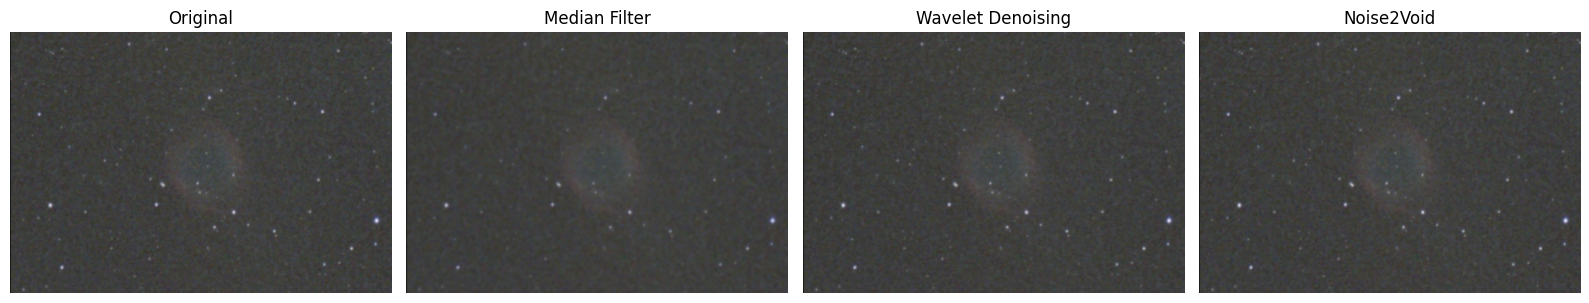

In [ ]:
import matplotlib.pyplot as plt

# Display the images
titles = ['Original', 'Median Filter', 'Wavelet Denoising', 'Noise2Void']
images = [image_rgb, median_rgb, wavelet_rgb, noise2void_rgb]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101


In [ ]:
import os

# Check the folder structure under UCF101
dataset_path = '/kaggle/input/ucf101/UCF101'
for root, dirs, files in os.walk(dataset_path):
    print("📁", root)
    for d in dirs:
        print(" ┣━", d)
    for f in files[:5]:  # Show only first 5 files to avoid overload
        print(" ┗━", f)
    break  # Only show top-level content for now


📁 /kaggle/input/ucf101/UCF101
 ┣━ UCF-101


In [ ]:
import kagglehub
import os, shutil, random

# Download dataset
path = kagglehub.dataset_download("pevogam/ucf101")
print("Path to dataset files:", path)

# ✅ Corrected source path based on your folder structure
SOURCE_DIR = os.path.join(path, 'UCF101', 'UCF-101')  # Corrected path
DEST_DIR = './UCF101_subset'
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    selected = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)
    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)


Path to dataset files: /kaggle/input/ucf101


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 112
FRAMES_PER_VIDEO = 16
FRAME_INTERVAL = 5  # Every 5th frame

def extract_frames(video_path, max_frames=FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % FRAME_INTERVAL == 0:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frames.append(frame)
        frame_count += 1
        if len(frames) == max_frames:
            break
    cap.release()

    # Pad if frames < max_frames
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))

    return np.array(frames)


In [ ]:
X = []
y = []
label_encoder = LabelEncoder()
labels = os.listdir(DEST_DIR)

for label in labels:
    folder = os.path.join(DEST_DIR, label)
    for file in os.listdir(folder):
        video_path = os.path.join(folder, file)
        frames = extract_frames(video_path)
        X.append(frames)
        y.append(label)

X = np.array(X)
y = label_encoder.fit_transform(y)

# Ensure the shapes are consistent
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Verify shapes after splitting and encoding
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)


X shape: (98, 16, 112, 112, 3)
y shape: (98,)
X_train shape: (78, 16, 112, 112, 3)
y_train_cat shape: (78, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

IMG_SIZE = 112  # Keep IMG_SIZE as 112 to retain reasonable spatial dimensions
FRAMES_PER_VIDEO = 16

model = Sequential([
    # 3D CNN layers to capture spatial and temporal features
    Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling3D(pool_size=(2, 2, 2), padding='same'),
    Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding='same'),
    Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding='same'),

    Flatten(),  # Flatten the output from 3D to 1D
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(SELECTED_CLASSES), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_21 (Conv3D)              │ (None, 16, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 8, 56, 56, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 8, 56, 56, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 4, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 2, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,125,893 (50.07 MB)

 Trainable params: 13,125,893 (50.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=10, batch_size=2)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.1583 - loss: 266.6541 - val_accuracy: 0.3000 - val_loss: 1.7448
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4169 - loss: 1.4213 - val_accuracy: 0.3500 - val_loss: 1.8065
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7301 - loss: 1.0140 - val_accuracy: 0.4500 - val_loss: 2.9052
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8735 - loss: 0.6519 - val_accuracy: 0.5500 - val_loss: 3.3006
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6638 - loss: 1.0141 - val_accuracy: 0.5500 - val_loss: 2.4547
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9126 - loss: 0.2370 - val_accuracy: 0.6000 - val_loss: 3.3459
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9787 - loss: 0.1382 - val_accuracy: 0.5500 - val_loss: 6.2459
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9140 - loss: 0.3628 - val_accuracy: 0.6000 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

   Basketball       0.50      0.25      0.33         4
       Biking       0.50      0.75      0.60         4
     JumpRope       0.80      1.00      0.89         4
PlayingGuitar       0.75      0.75      0.75         4
       Typing       0.67      0.50      0.57         4

     accuracy                           0.65        20
    macro avg       0.64      0.65      0.63        20
 weighted avg       0.64      0.65      0.63        20



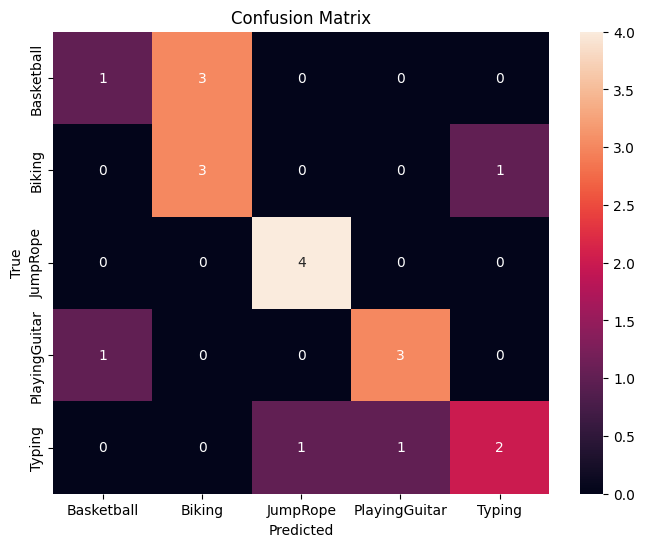

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.filters import median
from skimage.restoration import denoise_wavelet
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

# --- Helper function to add salt and pepper noise ---
def add_salt_pepper_noise(img, amount=0.05):
    row, col, ch = img.shape
    num_salt = np.ceil(amount * img.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape[:2]]
    noisy = img.copy()
    noisy[coords[0], coords[1], :] = 255

    num_pepper = np.ceil(amount * img.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape[:2]]
    noisy[coords[0], coords[1], :] = 0
    return noisy.astype(np.uint8)

# --- Noise2Void Model ---
def n2v_model(input_shape=(None, None, 3), filters=32, n_conv=3):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(n_conv):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(input_shape[-1], (1, 1), activation=None, padding='same')(x)
    return Model(inputs, outputs)

class MaskedMSE(Callback):
    def __init__(self):
        super().__init__()
        self.masks = None

    def on_train_batch_begin(self, batch, logs=None):
        if self.model.inputs[0].shape[1] is not None and self.model.inputs[0].shape[2] is not None:
            batch_size = tf.shape(self.model.inputs[0])[0]
            height = self.model.inputs[0].shape[1]
            width = self.model.inputs[0].shape[2]
            mask = np.random.randint(0, 2, size=(batch_size, height, width, 1))
            self.masks = tf.cast(mask, tf.float32)
            masked_inputs = self.model.inputs[0] * (1 - self.masks)
            self.model.inputs = [masked_inputs, self.model.inputs[1]] # Keep the original noisy image as target

    def on_predict_batch_begin(self, batch, logs=None):
        if self.model.inputs[0].shape[1] is not None and self.model.inputs[0].shape[2] is not None:
            batch_size = tf.shape(self.model.inputs[0])[0]
            height = self.model.inputs[0].shape[1]
            width = self.model.inputs[0].shape[2]
            mask = np.random.randint(0, 2, size=(batch_size, height, width, 1))
            masked_inputs = self.model.inputs[0] * (1 - tf.cast(mask, tf.float32))
            self.model.inputs = [masked_inputs]

# Modified masked_mse function to accept the callback instance
def masked_mse(callback):
    def loss(y_true, y_pred):
        mask = tf.cast(callback.masks, tf.float32)
        return tf.reduce_mean(tf.square(y_true - y_pred) * mask)
    return loss

# --- Load your images ---
image1 = cv2.imread('/content/extracted_frames/frame_0000.jpg')  # Replace with your image paths
image2 = cv2.imread('/content/extracted_frames/frame_0002.jpg')
image3 = cv2.imread('/content/extracted_frames/frame_0003.jpg')
images = [image1, image2, image3]

results = []

for i, original_image in enumerate(images):
    if original_image is None:
        print(f"Error: Could not load image {i+1}")
        continue

    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    noisy_image = add_salt_pepper_noise(original_image_rgb.copy(), amount=0.05)

    # Apply Median Filter (color channels)
    footprint = np.ones((3, 3), dtype=bool)  # A 3x3 footprint for filtering
    denoised_median = np.zeros_like(noisy_image)
    for c in range(3):  # Loop through each color channel (R, G, B)
        denoised_median[:, :, c] = median(noisy_image[:, :, c], footprint=footprint, mode='reflect', cval=0.0)

    # Apply Wavelet Denoising (Process each channel separately)
    denoised_wavelet = np.zeros_like(noisy_image, dtype=np.float32)
    for c in range(3):  # Loop through each color channel (R, G, B)
        denoised_wavelet[:, :, c] = denoise_wavelet(noisy_image[:, :, c], method='VisuShrink', mode='soft')

    # --- Noise2Void Denoising ---
    n2v_model_instance = n2v_model(input_shape=noisy_image.shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    masked_mse_callback = MaskedMSE()  # Instantiate the callback
    n2v_model_instance.compile(optimizer=optimizer, loss=masked_mse(masked_mse_callback)) # Pass the callback to the loss
    n2v_model_instance.callback = masked_mse_callback # Assign the callback to the model

    # Reshape for N2V training (add batch dimension)
    noisy_image_expanded = np.expand_dims(noisy_image, axis=0)
    original_image_expanded = np.expand_dims(original_image_rgb, axis=0).astype(np.float32) / 255.0

    n2v_model_instance.fit(noisy_image_expanded, original_image_expanded, epochs=10, verbose=0, callbacks=[masked_mse_callback])  # Pass the callback during fit
    denoised_n2v_normalized = n2v_model_instance.predict(np.expand_dims(noisy_image, axis=0))
    denoised_n2v = (denoised_n2v_normalized[0] * 255).astype(np.uint8)

    # --- Calculate metrics ---
    psnr_median = peak_signal_noise_ratio(original_image_rgb, denoised_median)
    ssim_median = structural_similarity(original_image_rgb, denoised_median, multichannel=True)
    mse_median = mean_squared_error(original_image_rgb, denoised_median)

    psnr_wavelet = peak_signal_noise_ratio(original_image_rgb, denoised_wavelet)
    ssim_wavelet = structural_similarity(original_image_rgb, denoised_wavelet, multichannel=True)
    mse_wavelet = mean_squared_error(original_image_rgb, denoised_wavelet)

    psnr_n2v = peak_signal_noise_ratio(original_image_rgb, denoised_n2v)
    ssim_n2v = structural_similarity(original_image_rgb, denoised_n2v, multichannel=True)
    mse_n2v = mean_squared_error(original_image_rgb, denoised_n2v)

    results.append({
        'image': f'Image {i+1}',
        'median': {'PSNR': psnr_median, 'SSIM': ssim_median, 'MSE': mse_median},
        'wavelet': {'PSNR': psnr_wavelet, 'SSIM': ssim_wavelet, 'MSE': mse_wavelet},
        'noise2void': {'PSNR': psnr_n2v, 'SSIM': ssim_n2v, 'MSE': mse_n2v}
    })

# --- Print the comparison results ---
for result in results:
    print(f"\n--- {result['image']} ---")
    for method, metrics in result.items():
        if method != 'image':
            print(f"{method.capitalize()}: PSNR={metrics['PSNR']:.2f}, SSIM={metrics['SSIM']:.4f}, MSE={metrics['MSE']:.2f}")

    # --- Visualize the results ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(noisy_image)
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(denoised_median.astype(np.uint8)) # Ensure correct data type for display
    plt.title(f'Median\nPSNR: {psnr_median:.2f}, SSIM: {ssim_median:.4f}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(denoised_wavelet.astype(np.uint8)) # Ensure correct data type for display
    plt.title(f'Wavelet\nPSNR: {psnr_wavelet:.2f}, SSIM: {ssim_wavelet:.4f}')
    plt.axis('off')

    plt.show()

    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image)
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_n2v)
    plt.title(f'Noise2Void\nPSNR: {psnr_n2v:.2f}, SSIM: {ssim_n2v:.4f}')
    plt.axis('off')
    plt.show()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
